# Data filtering, instance count and dataset split scripts. Run only whats needed, when needed.


## To count insts and remove detection with few points

PS Change hard-coded '/home/danilo' paths according to your path.

In [ ]:
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# COUNT INSTANCES SCRIPT

# bev image coordinates format
def get_corners(x, y, w, l, yaw):
    trackletBox = np.array([  # in bev coordinates around zero point and without orientation yet
            [w / 2, w / 2, -w / 2, -w / 2], \
            [-l / 2, l / 2, l / 2, -l / 2], \
            [0, 0, 0, 0]])
    rotMat = np.array([
            [np.cos(yaw), -np.sin(yaw), 0.0],
            [np.sin(yaw), np.cos(yaw), 0.0],
            [0.0, 0.0, 1.0]])
    res = 10/608
    translation = [x/res, y/res+304, 0]
    
    cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (4, 1)).T
    box3d = cornerPosInVelo.transpose()

    return box3d

def drawRotatedBox(img, x, y, w, l, yaw, color):
    # Convert the points to a NumPy array
    points = np.delete(get_corners(x,y,w,l,yaw).astype(np.int32), 2, axis=1)[:, ::-1]
    cv2.polylines(img, [points], True, color, 1)
    #corners_int = bev_corners.reshape(-1, 2)
    cv2.line(img, (int(points[0, 0]), int(points[0, 1])), (int(points[1, 0]), int(points[1, 1])), (255, 255, 0), 1)

path_r = '/home/danilo/humble_ws/data_dump/'
##Read DataFrame file:
df = pd.read_csv('/home/danilo/humble_ws/src/datagen_scripts/gz_configs/data_frame_dict.csv', index_col='Name')
res = 10 / 608
black_pixel = np.array([0, 0, 0], dtype=np.uint8)
min_num_pixels = 15
filter_detections = True
sample = 0
os_detec = 0
#vars

for i in range(68,69):
    os_detec = 0
    # i = 49
    path_l = path_r+str(i)+'/annotations/'
    path_sl = path_r+str(i)+'/seg_labels/'
    ann_file_list = os.listdir(path_l)
    ann_files = sorted([file for file in ann_file_list if not file.lower().endswith('_f.txt')])
    for file in ann_files[0:]:
        bev_map = cv2.imread(path_r+str(i)+'/bev_maps'+'/'+file[:-4]+'.png')
        seg_label = cv2.imread(path_sl+file[:-4]+'.png', cv2.IMREAD_GRAYSCALE)

        # Open the file in read mode
        with open(path_l+'/'+file, "r") as filecont:
            # Read all lines into a list
            lines = filecont.readlines()
            #print(lines)
            #lines_new = lines
            lines_new = []

        for line in lines[:]:
            #print(line)
            linee = line.rstrip()
            line_parts = linee.split(' ')

            if(filter_detections == True):
                if int(line_parts[0]) == 7: #palletbox offset
                    #print('pallet_jack detected')
                    point_vector = np.array([0.08223684, 0, 1])
                    transformation_matrix = np.array([
                            [np.cos(float(line_parts[7])), -np.sin(float(line_parts[7])), float(line_parts[1])],
                            [np.sin(float(line_parts[7])), np.cos(float(line_parts[7])), float(line_parts[2])],
                            [0, 0, 1]
                            ])
                    # Perform the transformation
                    transformed_point_vector = np.dot(transformation_matrix, point_vector)
                    # Extract the transformed coordinates (x', y')
                    transformed_x, transformed_y = transformed_point_vector[:2]
                    line = line.replace(f'{line_parts[0]} {line_parts[1]} {line_parts[2]} {line_parts[3]} {line_parts[4]} {line_parts[5]} {line_parts[6]} {line_parts[7]}',
                                        f'{line_parts[0]} {str(transformed_x)} {str(transformed_y)} {line_parts[3]} {str(70)} {line_parts[5]} {line_parts[6]} {line_parts[7]}')
                    os_detec +=1
                if int(line_parts[0]) == 13: #mecanum offset
                    # point_vector = np.array([0, -0.115131576, 1])
                    point_vector = np.array([0, 0, 1])
                    transformation_matrix = np.array([
                            [np.cos(float(line_parts[7])), -np.sin(float(line_parts[7])), float(line_parts[1])],
                            [np.sin(float(line_parts[7])), np.cos(float(line_parts[7])), float(line_parts[2])],
                            [0, 0, 1]
                            ])
                    # Perform the transformation
                    transformed_point_vector = np.dot(transformation_matrix, point_vector)
                    # Extract the transformed coordinates (x', y')
                    transformed_x, transformed_y = transformed_point_vector[:2]
                    line = line.replace(f'{line_parts[0]} {line_parts[1]} {line_parts[2]} {line_parts[3]} {line_parts[4]} {line_parts[5]} {line_parts[6]} {line_parts[7]}',
                                        f'{line_parts[0]} {str(transformed_x)} {str(transformed_y)} {line_parts[3]} {line_parts[4]} {str(58)} {line_parts[6]} {line_parts[7]}')
                    os_detec +=1
                    #print('Mecanum Lift detected')
                # Define the coordinates for the rotated and cropped area
                x, y, width, height = (float(line_parts[1])//res), (float(line_parts[2])//res)+304, float(line_parts[4]), float(line_parts[5])  # Example coordinates, adjust as needed

                degrees = float(line_parts[7]) * (180 / np.pi)
                count = 0
                #corners
                # Get the rotated bounding box in the rotated image
                #rotated_bbox = cv2.boxPoints(((y + width / 2, x + height / 2), (width, height), -degrees))
                rotated_bbox = cv2.boxPoints(((x, y), (width, height), degrees))

                rotated_bbox = np.int0(rotated_bbox)[:, ::-1]

                #mask+polygon
                # Create a binary mask for the rotated bounding box
                mask = np.zeros_like(bev_map[:, :, 0], dtype=np.uint8)
                cv2.drawContours(mask, [rotated_bbox], 0, 1, thickness=cv2.FILLED)
                #save first mask
                if sample <= 0:
                    mask_sample = mask
                    bev_sample = bev_map
                    rotated_box_sample = rotated_bbox
                    sample += 1
                

                #indices
                indices = np.transpose(np.where(mask != 0))
                #print(np.transpose(indices))
                for u, v in indices:
                    if (bev_map[u,v] != black_pixel).any():
                        count += 1

                if count >= min_num_pixels:
                    lines_new.append(line)
                else:
                    #del lines[line.index]

                    #print(f'deleted detection!{file}')

                    # lines_new.remove(line)

                    for u, v in indices:
                        if (seg_label[u,v] == int(line_parts[0])+1):
                            seg_label[u,v] = 0


                    
                    continue



            for name in df.index:
                if int(df['label_id'][name])-1 == int(line_parts[0]):
                    df.loc[name,'total_count'] += 1

        name = file[:-4]
        out_file = f'{path_l}{name}_f.txt'
        out_file_seg = f'{path_sl}{name}_f.png'
        #print(out_file)

        if filter_detections == True:
            with open(out_file, 'w') as output_file:
                output_file.writelines(lines_new)
            cv2.imwrite(out_file_seg, seg_label)

        if os_detec ==10:
            # Display the image using Matplotlib
            seg_img = seg_label*10+50
            for line in lines_new:
                linee = line.rstrip()
                line_parts = linee.split(' ')
                drawRotatedBox(seg_img, float(line_parts[1]), float(line_parts[2]), float(line_parts[4]), float(line_parts[5]), float(line_parts[7]), color=([255, 255, 255]))
                drawRotatedBox(bev_map, float(line_parts[1]), float(line_parts[2]), float(line_parts[4]), float(line_parts[5]), float(line_parts[7]), color=([255, 255, 255]))
            seg_img = cv2.cvtColor(seg_img.astype(np.uint8), cv2.COLOR_GRAY2RGB)
            out_img = np.concatenate((bev_map, seg_img), axis=1)
            plt.figure(figsize=(6, 12))
            imshow_obj = plt.imshow(out_img)
            plt.title('Seg-OBB (Press any key to iterate)')
            #plt.colorbar()
            #plt.axis('off')  # Hide axis labels and ticks (optional)
            plt.show(block=False)
            #Wait for a key press or close the window to continue
            # while not plt.waitforbuttonpress():
            #     pass
            #Close the Matplotlib window
            #plt.close()
            imshow_obj.remove()
    print(f'FINISHED {i}')


print(df['total_count'])


## To display an example image from the dataset

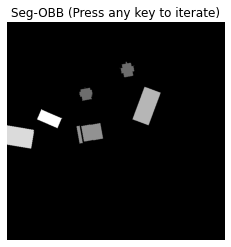

In [2]:
seg_label = cv2.imread('/home/danilo/humble_ws/data_dump/68/seg_labels/000005_f.png', cv2.IMREAD_GRAYSCALE) +50
imshow_obj = plt.imshow(seg_label, cmap='gray')
plt.title('Seg-OBB (Press any key to iterate)')
plt.axis('off')  # Hide axis labels and ticks (optional)
plt.show(block=False)

imshow_obj.remove()

## SPLIT SCRIPT

In [54]:
import shutil
import stat
import os

idx = 8250
val_idx = 0
test_idx = 0

def copy_file(src_path, dest_path):
    try:
        # Copy the file to the new destination
        shutil.copy2(src_path, dest_path)
        #print(f"File copied successfully: {dest_path}")
    except Exception as e:
        print(f"Error copying or renaming file: {e}")
        #print(len(lidar_files),len(ann_files))

for i in range(0,50):
    src_path = '/home/danilo/humble_ws/data_dump/'+str(i)

    lidar_file_list = os.listdir(src_path+'/lidar')
    lidar_files = sorted([file for file in lidar_file_list if file.lower().endswith('.bin')])
    print(lidar_files)

    ann_file_list = os.listdir(src_path+'/annotations')
    ann_files = sorted([file for file in ann_file_list if file.lower().endswith('_f.txt')])
    #print(int(len(ann_files)*0.8))

    seg_file_list = os.listdir(src_path+'/seg_labels')
    seg_files = sorted([file for file in seg_file_list if file.lower().endswith('_f.png')])
    #print(int(len(ann_files)*0.8))
    
    
    dest_path =  '/home/danilo/Desktop/kitti/synth_depot_dataset/'#não muda
    #src_file_list = 
    #src_ann_list = 
    split_int = int(len(ann_files)*0.8)+5
    for file in lidar_files[5:split_int]: #remove last 20 %
        dest_lidar_file = os.path.join(dest_path, 'train', 'lidar', f'{idx:06d}.bin')
        dest_seg_file = os.path.join(dest_path, 'train', 'seg_labels', f'{idx:06d}.png')
        dest_ann_file = os.path.join(dest_path, 'train', 'label', f'{idx:06d}.txt')
        src_lidar_file = os.path.join(src_path, 'lidar',  file)
        src_seg_file = os.path.join(src_path, 'seg_labels',  file[:-4]+'_f.png')
        src_ann_file = os.path.join(src_path, 'annotations',  file[:-4]+'_f.txt')
        os.chmod(src_lidar_file, 0o664)
        os.chmod(src_seg_file, 0o664)
        os.chmod(src_ann_file, 0o664)
        copy_file(src_lidar_file,dest_lidar_file)
        copy_file(src_seg_file,dest_seg_file)
        #print(src_seg_file,dest_seg_file)
        copy_file(src_ann_file,dest_ann_file)
        idx += 1


    for file in lidar_files[int(len(ann_files)*0.8):]: #last 20 % (aproximadamente)
        dest_lidar_file = os.path.join(dest_path, 'val', 'lidar', f'{val_idx:06d}.bin')
        dest_seg_file = os.path.join(dest_path, 'val', 'seg_labels', f'{val_idx:06d}.png')
        dest_ann_file = os.path.join(dest_path, 'val', 'label', f'{val_idx:06d}.txt')
        src_lidar_file = os.path.join(src_path, 'lidar',  file)
        src_seg_file = os.path.join(src_path, 'seg_labels',  file[:-4]+'_f.png')
        src_ann_file = os.path.join(src_path, 'annotations',  file[:-4]+'_f.txt')
        os.chmod(src_lidar_file, 0o664)
        os.chmod(src_seg_file, 0o664)
        os.chmod(src_ann_file, 0o664)
        copy_file(src_lidar_file,dest_lidar_file)
        copy_file(src_seg_file,dest_seg_file)
        copy_file(src_ann_file,dest_ann_file)
        val_idx += 1

for i in range(51, 60):
    src_path = '/home/danilo/humble_ws/data_dump/'+str(i)

    lidar_file_list = os.listdir(src_path+'/lidar')
    lidar_files = sorted([file for file in lidar_file_list if file.lower().endswith('.bin')])
    #print(len(lidar_files))

    ann_file_list = os.listdir(src_path+'/annotations')
    ann_files = sorted([file for file in ann_file_list if file.lower().endswith('_f.txt')])
    #print(int(len(ann_files)*0.8))

    seg_file_list = os.listdir(src_path+'/seg_labels')
    seg_files = sorted([file for file in seg_file_list if file.lower().endswith('_f.png')])
    #print(int(len(ann_files)*0.8))
    
    
    dest_path =  '/home/danilo/Desktop/kitti/synth_depot_dataset/'
    #src_file_list = 
    #src_ann_list = 
    #split_int = int(len(ann_files)*0.8)+5
    for file in lidar_files[5:]: 
        dest_lidar_file = os.path.join(dest_path, 'test', 'lidar', f'{test_idx:06d}.bin')
        dest_seg_file = os.path.join(dest_path, 'test', 'seg_labels', f'{test_idx:06d}.png')
        dest_ann_file = os.path.join(dest_path, 'test', 'label', f'{test_idx:06d}.txt')
        dest_rgb_file = os.path.join(dest_path, 'test', 'image', f'{test_idx:06d}.png')
        src_rgb_file = os.path.join(src_path, 'bounding_box_3d_data', 'images',  f'image_0{file[:-4]}.png')
        src_lidar_file = os.path.join(src_path, 'lidar',  file)
        src_seg_file = os.path.join(src_path, 'seg_labels',  file[:-4]+'_f.png')
        src_ann_file = os.path.join(src_path, 'annotations',  file[:-4]+'_f.txt')
        copy_file(src_lidar_file,dest_lidar_file)
        copy_file(src_seg_file,dest_seg_file)
        copy_file(src_ann_file,dest_ann_file)
        copy_file(src_rgb_file,dest_rgb_file)
        test_idx += 1